### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import requests
import ads
import ocifs
import os
import pandas as pd
import sqlalchemy as db
import time as tm

from ads.dataset.factory import DatasetFactory
from ads.database.connection import Connector

from matplotlib import pyplot as plt

In [2]:
response = requests.get("https://oracle.com")
print(response.status_code)
assert response.status_code==200, "Internet connection failed"

200


In [3]:
%env TNS_ADMIN=/home/datascience/.database/textreviews_high
TNS_ADMIN ='/home/datascience/.database/textreviews_high'
# TNS_ADMIN ='/home/datascience/.database/textreviews_high'
%env ADW_SID=textreviews_high
ADW_SID = 'textreviews_high'
# ADW_SID = 'textreviews_high'
%env ADW_USER=ADMIN
%env ADW_PASSWORD=Oracle_12345
ADW_USER = 'ADMIN'
ADW_PASSWORD = 'Oracle_12345'

env: TNS_ADMIN=/home/datascience/.database/textreviews_high
env: ADW_SID=textreviews_high
env: ADW_USER=ADMIN
env: ADW_PASSWORD=Oracle_12345


In [11]:
## Store credentials
creds = {}
creds['tns_admin'] = '/home/datascience/.database/textreviews_high/'
creds['sid'] = 'textreviews_high'
creds['user'] = 'ADMIN'
creds['password'] = 'Oracle_12345'

os.environ['TNS_ADMIN'] = creds['tns_admin']
os.environ['ADW_USER'] = creds['user']
os.environ['ADW_PASSWORD'] = creds['password']
os.environ['ADW_SID'] = creds['sid']

connection_parameters = {
      "user_name": "ADMIN",
      "password": "Oracle_12345",
      "service_name": "textreviews_high",
      "wallet_location": "/home/datascience/Wallet_TextReviews.zip",
      }

## DATABASE connection setup
connect = 'sqlplus ' + creds['user'] + '/' + creds['password'] + '@' + creds['sid']
uri=f'oracle+cx_oracle://{os.environ["ADW_USER"]}:{os.environ["ADW_PASSWORD"]}@{os.environ["ADW_SID"]}'
engine_opt = db.create_engine(uri, arraysize = 2000)
engine_not_opt = db.create_engine(uri)


## create a dictionary for storing times which are measures by ...
## loading data from diffrent storages

# files = ['HOTEL_REVIEWS', 'HOTEL_REVIEWS_1547KBY17', 'HOTEL_REVIEWS_516KBY51']
files =['TRIP_DATA_10MMBY19','TRIP_DATA_10MMBY38','TRIP_DATA_1MMBY19','TRIP_DATA_1MMBY38','TRIP_DATA_100KBY19','TRIP_DATA_100KBY38']
# files = ['TABLE100KBY19','TABLE100KBY38', 'TABLE100KBY78', 'TABLE200KBY19', 'TABLE200KBY38', 'TABLE200KBY78','TABLE500KBY19',
#          'TABLE500KBY38','TABLE500KBY78','TABLE700KBY19','TABLE700KBY38','TABLE700KBY78','TABLE800KBY19','TABLE800KBY38',
#          'TABLE800KBY78','TABLE1000KBY19','TABLE1000KBY38','TABLE1000KBY78','TABLE1200KBY19','TABLE1200KBY38','TABLE1200KBY78','TABLE1500KBY19',
#          'TABLE1500KBY38', 'TABLE1500KBY78']

cols = ['ADW_Alchemy_opt', 'ADW_Alchemy_not_opt',
        'ADW_PD.ADS.SQL',
        'ADW_PD.SQL_opt', 'ADW_PD.SQL_not_opt',
        'Read OBS', 'Read OBS ocifs', 'Read Local']
res_dic = {}
res_dic['DateTime'] =[]
for fl in files:
    for cl in cols:
        res_dic[fl+'-'+cl]=[]

In [12]:
def AlchemyDB(file_name, eng):
    '''compute elapsed time using Alchemy for fetching data'''
    Start_time  = tm.time() 
    connection = eng.connect()
    metadata = db.MetaData()
    hotel_reviews = db.Table(file_name, metadata, autoload=True, autoload_with=eng)
    # the following line means SELECT * FROM hotel_reviews
    query = db.select([hotel_reviews])
    ResultProxy = connection.execute(query)
    ResultSet = ResultProxy.fetchall()
    duration = tm.time()-Start_time
    return duration

def adsSqlRead(file_name, connection_params):
    '''compute elapsed time using ads for fetching data'''
    Start_time  = tm.time()
    query = "SELECT * FROM ADMIN.{}".format(file_name)
    df = pd.DataFrame.ads.read_sql(query,
                       connection_parameters=connection_params,
                      )
    duration = tm.time()-Start_time
    return duration

def PandasSqlRead(file_name, eng):
    '''compute elapsed time using PANDAS-SQL for fetching data'''
    Start_time  = tm.time()
    df = pd.read_sql('SELECT * FROM ADMIN.{}'.format(file_name), con=eng)
    duration = tm.time()-Start_time
    return duration

def readFromAttachedSpace(pth, file_name):
    ''' compute elapsed time for reading data from local atatched space '''
    Start_time  = tm.time()
    df = pd.read_csv(pth+file_name+'.csv') #pth ='~/conda/data/'
    duration = tm.time()-Start_time
    return duration     
            
def readFromOBS(file_name):
    Start_time  = tm.time()
    fn = 'oci://SailGP@bigdatadatasciencelarge/{}.csv'.format(file_name)
    ds = DatasetFactory.open(fn, storage_options = {"config": "~/.oci/config", "profile": "DEFAULT_USER"})
    duration = duration = tm.time()-Start_time
    return duration

def readFromOBSwithOCIFS(file_name):
    Start_time  = tm.time()
    fn = 'oci://SailGP@bigdatadatasciencelarge/{}.csv'.format(file_name)
    df = pd.read_csv( fn,
        storage_options={"config": "~/.oci/config"},
    )
    duration = duration = tm.time()-Start_time
    return duration


def save_res_dic(resutl_dic):
    '''Convert Reslts Dictionary to a DataFrame and save it.
       Average of columns are inserted to the last row of DataFrame
       before saving to the disk.
    ''' 
    SummaryOF20Runs = pd.DataFrame(resutl_dic)
    AveOF20Runs = SummaryOF20Runs.mean()
    current_time = str(pd.to_datetime( int(tm.time()-7*3600),unit='s'))
    Summary = SummaryOF20Runs.append(AveOF20Runs, ignore_index=True)
    Summary.to_csv('~/conda/data/ADWdataAccessSummary-{}.csv'.format(current_time))

def plotADWbenchmarks(DF, tag, text,file_names):
    '''
        Plots columns of the result DataFrame
    '''
#     files = ['HOTEL_REVIEWS', 'HOTEL_REVIEWS_1547KBY17', 'HOTEL_REVIEWS_516KBY51']
#     files =['TRIP_DATA_10MMBY19','TRIP_DATA_10MMBY38','TRIP_DATA_1MMBY19','TRIP_DATA_1MMBY38','TRIP_DATA_100KBY19','TRIP_DATA_100KBY38']
#     color = ['black','dimgrey', 'blue', 'royalblue','olive','y']
    idx = 0
    fig = plt.figure(figsize=(16,3))
    for fl in file_names:
        plt.plot(pd.to_datetime(DF['DateTime'])[:-1],DF[fl+'-'+tag][:-1],'.-', ) #color = color[idx]
        plt.grid()
        plt.legend(files)
        plt.title(text,fontsize=16,ha='center')
        plt.ylabel('Second', fontsize=12)
        idx +=1

In [ ]:
%%time

'''
This section loops through the Three DATASETS and measures elapsed time
for fetching them from different storages namely: ADW, OBS, and attached space.
We also benchmark speed of different SQL technologies.

HOTEL_REVIEWS_1547KBY17: 713.2 MB
HOTEL_REVIEWS_516Kby51:  713.2 MB
HOTEL_REVIEWS:           238.9 MB
'''


for jj in range(0,30):
    for rept in range(0,20):
        res_dic['DateTime'].append( str(pd.to_datetime( int(tm.time()-7*3600),unit='s')) )
        for fl in files:
            
            print(fl)

            ## rquery ADW using AlchemySQL
            # optimized query
            elapsed_time = AlchemyDB(fl, engine_opt)
            res_dic[fl+'-ADW_Alchemy_opt'].append(elapsed_time)
            
            # not optimized query
            elapsed_time = AlchemyDB(fl, engine_not_opt)
            res_dic[fl+'-ADW_Alchemy_not_opt'].append(elapsed_time)
            
            ## Using ADS
            elapsed_time = adsSqlRead(fl, connection_parameters)
            res_dic[fl+'-ADW_PD.ADS.SQL'].append(elapsed_time)
            
            ## Using pandas.read_sql
            # optimized query
            elapsed_time = PandasSqlRead(fl, engine_opt)
            res_dic[fl+'-ADW_PD.SQL_opt'].append(elapsed_time)
            
            # not optimized query
            elapsed_time = PandasSqlRead(fl, engine_not_opt)
            res_dic[fl+'-ADW_PD.SQL_not_opt'].append(elapsed_time)
            
            ## Read From Object Storage
            # OBS using ADS
            elapsed_time = readFromOBS(fl)
            res_dic[fl+'-Read OBS'].append(elapsed_time)
            print(elapsed_time)
            #OBS using ocifs
            elapsed_time = readFromOBSwithOCIFS(fl)
            res_dic[fl+'-Read OBS ocifs'].append(elapsed_time)
            print(elapsed_time)

            ## Read from local Hard Space
            elapsed_time = readFromAttachedSpace('~/conda/data/', fl)
            res_dic[fl+'-Read Local'].append(elapsed_time)
            
        print(rept)
        save_res_dic(res_dic)
#         print(res_dic['HOTEL_REVIEWS-ADW_pd.ads.sql_Fetch SEC'])

TRIP_DATA_10MMBY19


distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://10.0.1.40/39110/1 remote=inproc://10.0.1.40/39110/8>


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

77.70965480804443
63.6773681640625
TRIP_DATA_10MMBY38


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

161.3619430065155
127.09317278862
TRIP_DATA_1MMBY19


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

7.874054670333862
5.695929527282715
TRIP_DATA_1MMBY38


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

15.248483180999756
10.555092096328735
TRIP_DATA_100KBY19


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

2.6127376556396484
0.7874889373779297
TRIP_DATA_100KBY38


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

4.786234140396118
1.1247444152832031
0
TRIP_DATA_10MMBY19


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

71.90190029144287
62.469688415527344
TRIP_DATA_10MMBY38


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

159.30970692634583
137.83683943748474
TRIP_DATA_1MMBY19


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

8.585618019104004
5.360839128494263
TRIP_DATA_1MMBY38


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

16.230597019195557
11.0728440284729
TRIP_DATA_100KBY19


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

3.106444835662842
0.6159040927886963
TRIP_DATA_100KBY38


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

4.820475101470947
1.1534318923950195
1
TRIP_DATA_10MMBY19


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

94.45640230178833
87.49599647521973
TRIP_DATA_10MMBY38


In [18]:
df = pd.read_csv('~/conda/data/SummaryOFalchamey-2021-08-29 14:19:20.csv')

plotADWbenchmarks(df, 'ADW_Alchemy_opt', 'Reading from ADW using SQLalchemy: Optimized [arraysize = 1000]')
plotADWbenchmarks(df, 'ADW_PD.ADS.SQL', 'Reading from ADW using ADS.READ_SQL')
plotADWbenchmarks(df, 'ADW_PD.SQL_opt', 'Reading from ADW using PANDAS.READ_SQL: Optimized [arraysize = 1000]')

plotADWbenchmarks(df, 'ADW_Alchemy_not_opt', 'Reading from ADW using SQLalchemy: NOT Optimized')
plotADWbenchmarks(df, 'ADW_PD.ADS.SQL', 'Reading from ADW using ADS.READ_SQL')
plotADWbenchmarks(df, 'ADW_PD.SQL_not_opt', 'Reading from ADW using PANDAS.READ_SQL: NOT Optimized')

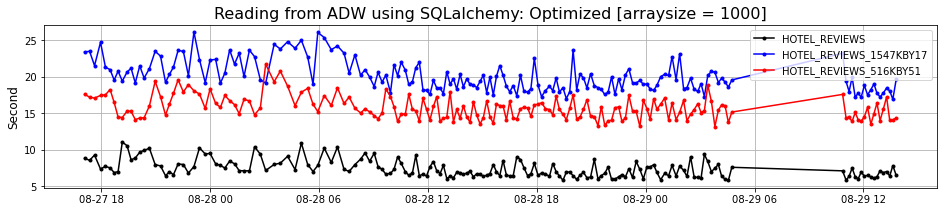

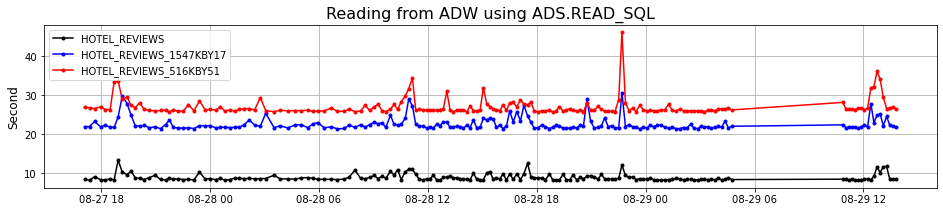

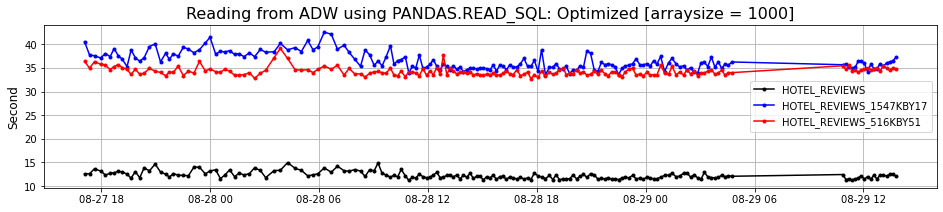

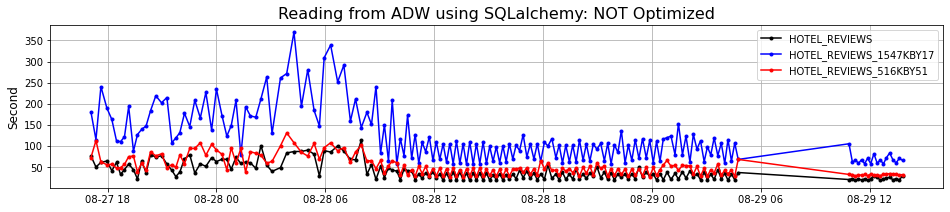

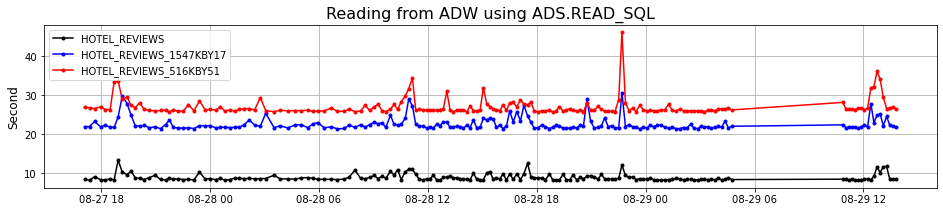

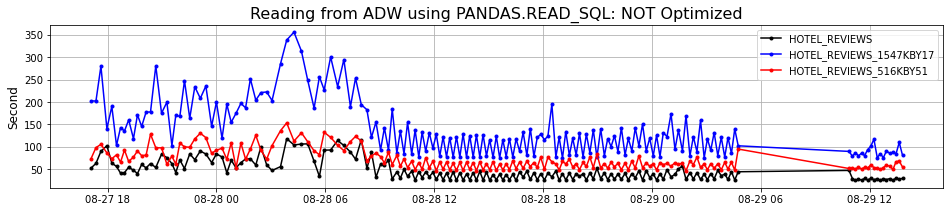

In [ ]:
''' Create MEAN and STD matrix'''
df = df.append(df.std(),ignore_index=True)
rows_idx = cols

df_reshape = pd.DataFrame(columns=files,index=rows_idx)

for cl in files:
    for rr in rows_idx:
        df_reshape.loc[rr,cl] = df[cl+'-'+rr][-2:].values.round(decimals = 1)
df_reshape

In [ ]:
# SummaryOF20Runs = pd.DataFrame(res_dic)
# AveOF20Runs = SummaryOF20Runs.mean()
# current_time = str(pd.to_datetime( int(tm.time()-7*3600),unit='s'))
# SummaryOFalchamey = SummaryOF20Runs.append(AveOF20Runs, ignore_index=True)
# SummaryOFalchamey
# SummaryOFalchamey.to_csv('~/conda/data/SummaryOFalchamey-{}.csv'.format(current_time))

In [ ]:
# files = ['HOTEL_REVIEWS', 'HOTEL_REVIEWS_1547KBY17', 'HOTEL_REVIEWS_516KBY51']
# cols = ['ADW_Fetch SEC', 'ADW_pd.ads.sql_Fetch SEC','ADW_pd.sql_Fetch SEC', 'Read OBS SEC']
# Labels= ['Alchemy']
# plot_tags = []
# fig = plt.plot(figsize = (14,3))
# plt.plot()

In [12]:
for ii in res_dic.keys():
#     res_dic[ii] = res_dic[ii][0:18]
    print(ii, len(res_dic[ii]) )

DateTime 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-ADW_Alchemy_opt 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-ADW_Alchemy_not_opt 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-ADW_PD.ADS.SQL 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-ADW_PD.SQL_opt 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-ADW_PD.SQL_not_opt 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-Read OBS 18
DATA_NYC_TAXI_TRIP_CSV_YELLOW_TRIPDATA_2020_01-Read Local 18


In [ ]:
# %%time

# !sqlplus -S $ADW_USER/$ADW_PASSWORD@$ADW_SID @/home/datascience/conda/data/readTablesFromADW.sql

In [ ]:
# import os
# import pandas as pd
# from sqlalchemy import create_engine
# from sqlalchemy import MetaData
# from sqlalchemy import Table
# from sqlalchemy import select
# uri=f'oracle+cx_oracle://{os.environ["ADW_USER"]}:{os.environ["ADW_PASSWORD"]}@{os.environ["ADW_SID"]}'

# #print(uri)
# engine = create_engine(uri)

In [ ]:
# %%time
# # df = pd.read_sql('SELECT * FROM ADMIN.SAILGP_SGP_SAIL_HISTORY', con=engine)
# df = pd.read_sql('SELECT * FROM ADMIN.HOTEL_REVIEWS', con=engine)
# # df.head(1)

In [ ]:
# %%time
# # engine = create_engine(uri)
# connection = engine.connect()
# metadata = MetaData()
# hotel_reviews = Table('HOTEL_REVIEWS', metadata, autoload=True, autoload_with=engine)

# ## SELECT * from HOTEL_REVIEWS
# query = select([hotel_reviews])
# ResultProxy = connection.execute(query)
# print('fetching...')
# ResultSet = ResultProxy.fetchall()
# ResultSet[0:1]

In [ ]:
# %%time

# credential = {'database_name': 'sailgp_high', 
#               'username': 'ADMIN', 
#               'password': 'Oracle_12345',
#               'database_type':'oracle'}

# connector = Connector(database_name=credential['database_name'],
#                           username=credential['username'], 
#                           password=credential['password'],
#                           database_type=credential['database_type'])
# sql_hotel_reviews = """
#     SELECT * 
#     FROM ADMIN.HOTEL_REVIEWS
#     """
# if "connector" in globals():
#     hotel_reviews = DatasetFactory.open(connector.uri, format="sql", 
#                                      table=sql_hotel_reviews,)
# else:
#     print("Skipping as it appears that you do not have connector configured.")

In [13]:
def PandasSqlRead(file_name, eng):
    '''compute elapsed time using PANDAS-SQL for fetching data'''
    Start_time  = tm.time()
    df = pd.read_sql('SELECT * FROM ADMIN.{}'.format(file_name), con=eng)
    duration = tm.time()-Start_time
    return df

In [15]:
df = PandasSqlRead('BHE_BHE_FEATURE_ENGINEERED', engine_opt)

In [16]:
import pandas as pd
variables = [ 'month', 'day', 'hour', 'ACTIVE_POWER_MEAN', 'active_power-1hrs', 'active_power-6hrs', 
 'active_power-12hrs', 'active_power-24hrs', 'AVR', 'ATM', 'ALT', 'MWS', 'MXW', 'MWD', 'AVA', 
 'PAS', 'VIS', 'DEW',  'PRE']
test = pd.read_csv('bhe_bhe_feature_engineered.csv')[variables]

input_data = test[0:1].to_json(orient='records',lines=True)
input_data

'{"month":2,"day":26,"hour":0,"ACTIVE_POWER_MEAN":337.1249872735,"active_power-1hrs":337.1249872735,"active_power-6hrs":719.50331668,"active_power-12hrs":519.7086929875,"active_power-24hrs":680.7730757201,"AVR":74,"ATM":953.062529284,"ALT":1222.5380438106,"MWS":9,"MXW":41,"MWD":414,"AVA":33,"PAS":4,"VIS":10,"DEW":94,"PRE":0.0836829751}\n'

In [17]:
import requests
import oci
from oci.signer import Signer

# User principal auth: 
#config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
#auth = Signer(
#  tenancy=config['tenancy'],
#  user=config['user'],
#  fingerprint=config['fingerprint'],
#  private_key_file_location=config['key_file'],
#  pass_phrase=config['pass_phrase'])

# Resource principal auth:
auth = oci.auth.signers.get_resource_principals_signer()

# replace with your own endpoint: 
endpoint = 'https://modeldeployment.us-phoenix-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.phx.amaaaaaanif7xwiaryynxmnf7m6py6m5bjpsqf2foaendsemyxf37mfstyuq/predict'

requests.post(endpoint, json=input_data, auth=auth).json()

{'prediction': '[567.4416317471155]'}

In [21]:
df['Time_Stamp'] = pd.to_datetime(df['timestamp'])

In [20]:
current_time = '2021-09-30 01:00:00'
pd.to_datetime(current_time)

Timestamp('2021-09-30 01:00:00')